<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:11:26] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


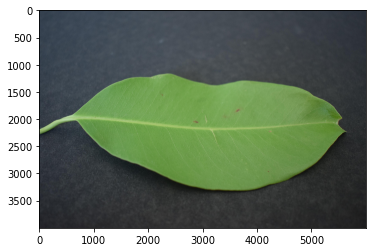

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

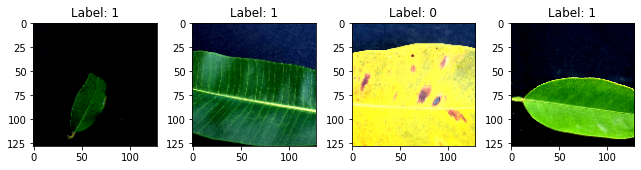

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:11:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:11:35] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2569803580336247 samples/sec                   batch loss = 1.5192452669143677 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2642252520939097 samples/sec                   batch loss = 0.6495449542999268 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2594420151413355 samples/sec                   batch loss = 0.5096491575241089 | accuracy = 0.5166666666666667


Epoch[1] Batch[20] Speed: 1.2662041210688988 samples/sec                   batch loss = 0.8876085877418518 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2621009147161164 samples/sec                   batch loss = 0.5792644023895264 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2654806486611738 samples/sec                   batch loss = 0.5474012494087219 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.2672258391401496 samples/sec                   batch loss = 0.3532046973705292 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.2662796199534478 samples/sec                   batch loss = 0.43325889110565186 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2687903449451452 samples/sec                   batch loss = 0.49640074372291565 | accuracy = 0.6222222222222222


Epoch[1] Batch[50] Speed: 1.2689098180302223 samples/sec                   batch loss = 0.267703652381897 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2673753664138445 samples/sec                   batch loss = 0.46840083599090576 | accuracy = 0.6045454545454545


Epoch[1] Batch[60] Speed: 1.2719302993899029 samples/sec                   batch loss = 0.3202548921108246 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2707371490909123 samples/sec                   batch loss = 0.765759289264679 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2695746718535657 samples/sec                   batch loss = 0.3876859247684479 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2782751789234588 samples/sec                   batch loss = 0.3471706509590149 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2702711911169837 samples/sec                   batch loss = 0.3857906460762024 | accuracy = 0.6375


Epoch[1] Batch[85] Speed: 1.272589924952522 samples/sec                   batch loss = 0.584362804889679 | accuracy = 0.6470588235294118


Epoch[1] Batch[90] Speed: 1.2679747868458813 samples/sec                   batch loss = 0.7713353037834167 | accuracy = 0.6472222222222223


Epoch[1] Batch[95] Speed: 1.271707009511491 samples/sec                   batch loss = 0.6541593074798584 | accuracy = 0.6394736842105263


Epoch[1] Batch[100] Speed: 1.267736215123535 samples/sec                   batch loss = 0.615827739238739 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.2707171298295359 samples/sec                   batch loss = 0.5978662371635437 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.269592829711707 samples/sec                   batch loss = 0.50412517786026 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2646510352072295 samples/sec                   batch loss = 0.5450286865234375 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2644344865638326 samples/sec                   batch loss = 0.9932368993759155 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.2738261145341483 samples/sec                   batch loss = 0.7765750885009766 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.2668670984646693 samples/sec                   batch loss = 0.7078661918640137 | accuracy = 0.6192307692307693


Epoch[1] Batch[135] Speed: 1.2723472977282406 samples/sec                   batch loss = 0.33489689230918884 | accuracy = 0.6240740740740741


Epoch[1] Batch[140] Speed: 1.2680513596136624 samples/sec                   batch loss = 0.4598176181316376 | accuracy = 0.6321428571428571


Epoch[1] Batch[145] Speed: 1.2664504335632747 samples/sec                   batch loss = 0.4040304124355316 | accuracy = 0.6327586206896552


Epoch[1] Batch[150] Speed: 1.2649308854643466 samples/sec                   batch loss = 1.497323751449585 | accuracy = 0.6366666666666667


Epoch[1] Batch[155] Speed: 1.269461028910757 samples/sec                   batch loss = 0.6043879985809326 | accuracy = 0.6387096774193548


Epoch[1] Batch[160] Speed: 1.2680359293131789 samples/sec                   batch loss = 0.2508302927017212 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.272344402973897 samples/sec                   batch loss = 0.8649132251739502 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.2673786215612495 samples/sec                   batch loss = 0.35119032859802246 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.267881167880586 samples/sec                   batch loss = 0.21936924755573273 | accuracy = 0.6514285714285715


Epoch[1] Batch[180] Speed: 1.2753438545629576 samples/sec                   batch loss = 0.10545571148395538 | accuracy = 0.6569444444444444


Epoch[1] Batch[185] Speed: 1.268602592159461 samples/sec                   batch loss = 1.0006309747695923 | accuracy = 0.6486486486486487


Epoch[1] Batch[190] Speed: 1.2647381712092851 samples/sec                   batch loss = 1.0215349197387695 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.2687318161431094 samples/sec                   batch loss = 0.4003131091594696 | accuracy = 0.6448717948717949


Epoch[1] Batch[200] Speed: 1.268492000407376 samples/sec                   batch loss = 0.8798986673355103 | accuracy = 0.64625


Epoch[1] Batch[205] Speed: 1.2658558915148985 samples/sec                   batch loss = 0.7346542477607727 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.2690923818069397 samples/sec                   batch loss = 0.7305627465248108 | accuracy = 0.6392857142857142


Epoch[1] Batch[215] Speed: 1.2677671573115037 samples/sec                   batch loss = 0.5945541858673096 | accuracy = 0.6395348837209303


Epoch[1] Batch[220] Speed: 1.26378461898179 samples/sec                   batch loss = 0.797210156917572 | accuracy = 0.634090909090909


Epoch[1] Batch[225] Speed: 1.2658621952032914 samples/sec                   batch loss = 0.5853234529495239 | accuracy = 0.6355555555555555


Epoch[1] Batch[230] Speed: 1.2768282888597882 samples/sec                   batch loss = 0.5123417973518372 | accuracy = 0.6380434782608696


Epoch[1] Batch[235] Speed: 1.2691903083131235 samples/sec                   batch loss = 0.4997349977493286 | accuracy = 0.6382978723404256


Epoch[1] Batch[240] Speed: 1.2703926747816179 samples/sec                   batch loss = 0.4385731518268585 | accuracy = 0.640625


Epoch[1] Batch[245] Speed: 1.2639705673510142 samples/sec                   batch loss = 0.3934647738933563 | accuracy = 0.6408163265306123


Epoch[1] Batch[250] Speed: 1.2694383603943358 samples/sec                   batch loss = 0.36018574237823486 | accuracy = 0.644


Epoch[1] Batch[255] Speed: 1.264148759692913 samples/sec                   batch loss = 0.6916948556900024 | accuracy = 0.6460784313725491


Epoch[1] Batch[260] Speed: 1.2628506591623727 samples/sec                   batch loss = 0.5003723502159119 | accuracy = 0.6461538461538462


Epoch[1] Batch[265] Speed: 1.266617085755222 samples/sec                   batch loss = 0.6814080476760864 | accuracy = 0.6490566037735849


Epoch[1] Batch[270] Speed: 1.2610884834194969 samples/sec                   batch loss = 0.5490529537200928 | accuracy = 0.6472222222222223


Epoch[1] Batch[275] Speed: 1.2619954405670384 samples/sec                   batch loss = 1.0279364585876465 | accuracy = 0.6472727272727272


Epoch[1] Batch[280] Speed: 1.2627864989486197 samples/sec                   batch loss = 0.42542368173599243 | accuracy = 0.6455357142857143


Epoch[1] Batch[285] Speed: 1.2749075481655725 samples/sec                   batch loss = 0.6043941974639893 | accuracy = 0.6429824561403509


Epoch[1] Batch[290] Speed: 1.2665948055560043 samples/sec                   batch loss = 0.7409565448760986 | accuracy = 0.6413793103448275


Epoch[1] Batch[295] Speed: 1.2638274593771748 samples/sec                   batch loss = 0.6569481492042542 | accuracy = 0.6423728813559322


Epoch[1] Batch[300] Speed: 1.2664126728104164 samples/sec                   batch loss = 0.45787912607192993 | accuracy = 0.64


Epoch[1] Batch[305] Speed: 1.266285067689564 samples/sec                   batch loss = 0.6153085827827454 | accuracy = 0.6385245901639345


Epoch[1] Batch[310] Speed: 1.269343564820426 samples/sec                   batch loss = 0.7860532999038696 | accuracy = 0.6387096774193548


Epoch[1] Batch[315] Speed: 1.2706718963214154 samples/sec                   batch loss = 0.532616913318634 | accuracy = 0.6412698412698413


Epoch[1] Batch[320] Speed: 1.2723869571891326 samples/sec                   batch loss = 0.42660582065582275 | accuracy = 0.6421875


Epoch[1] Batch[325] Speed: 1.269056287220419 samples/sec                   batch loss = 0.5612109899520874 | accuracy = 0.6423076923076924


Epoch[1] Batch[330] Speed: 1.2712471791890643 samples/sec                   batch loss = 0.6212408542633057 | accuracy = 0.6454545454545455


Epoch[1] Batch[335] Speed: 1.27311265016192 samples/sec                   batch loss = 0.8017471432685852 | accuracy = 0.6447761194029851


Epoch[1] Batch[340] Speed: 1.2796482412251942 samples/sec                   batch loss = 0.7437511086463928 | accuracy = 0.6470588235294118


Epoch[1] Batch[345] Speed: 1.2681296669889168 samples/sec                   batch loss = 0.5104628205299377 | accuracy = 0.6434782608695652


Epoch[1] Batch[350] Speed: 1.2682464271545928 samples/sec                   batch loss = 0.33228564262390137 | accuracy = 0.6435714285714286


Epoch[1] Batch[355] Speed: 1.2698692006905663 samples/sec                   batch loss = 1.0254360437393188 | accuracy = 0.643661971830986


Epoch[1] Batch[360] Speed: 1.2575210626631985 samples/sec                   batch loss = 1.0341496467590332 | accuracy = 0.6430555555555556


Epoch[1] Batch[365] Speed: 1.2614770603158276 samples/sec                   batch loss = 0.5056206583976746 | accuracy = 0.6452054794520548


Epoch[1] Batch[370] Speed: 1.2664707010225542 samples/sec                   batch loss = 0.26565122604370117 | accuracy = 0.6472972972972973


Epoch[1] Batch[375] Speed: 1.2584633892532346 samples/sec                   batch loss = 0.7202112674713135 | accuracy = 0.6473333333333333


Epoch[1] Batch[380] Speed: 1.2635184072387067 samples/sec                   batch loss = 0.5442249774932861 | accuracy = 0.6506578947368421


Epoch[1] Batch[385] Speed: 1.2668000425256363 samples/sec                   batch loss = 0.47932013869285583 | accuracy = 0.6512987012987013


Epoch[1] Batch[390] Speed: 1.268826040570298 samples/sec                   batch loss = 0.7065441012382507 | accuracy = 0.6487179487179487


Epoch[1] Batch[395] Speed: 1.2686593822342787 samples/sec                   batch loss = 0.4999593496322632 | accuracy = 0.649367088607595


Epoch[1] Batch[400] Speed: 1.260873721556492 samples/sec                   batch loss = 0.6860857009887695 | accuracy = 0.64875


Epoch[1] Batch[405] Speed: 1.2590394786381416 samples/sec                   batch loss = 0.43159839510917664 | accuracy = 0.6487654320987655


Epoch[1] Batch[410] Speed: 1.264145902123801 samples/sec                   batch loss = 0.6634979248046875 | accuracy = 0.65


Epoch[1] Batch[415] Speed: 1.262421717617874 samples/sec                   batch loss = 0.9340910315513611 | accuracy = 0.6512048192771084


Epoch[1] Batch[420] Speed: 1.2707088528192416 samples/sec                   batch loss = 0.6911793351173401 | accuracy = 0.6517857142857143


Epoch[1] Batch[425] Speed: 1.2648373340011898 samples/sec                   batch loss = 0.34821850061416626 | accuracy = 0.6535294117647059


Epoch[1] Batch[430] Speed: 1.2651788017673513 samples/sec                   batch loss = 0.8798865079879761 | accuracy = 0.6552325581395348


Epoch[1] Batch[435] Speed: 1.266183288784411 samples/sec                   batch loss = 1.155598759651184 | accuracy = 0.656896551724138


Epoch[1] Batch[440] Speed: 1.2708431269383005 samples/sec                   batch loss = 0.6298721432685852 | accuracy = 0.6579545454545455


Epoch[1] Batch[445] Speed: 1.2672790599126655 samples/sec                   batch loss = 0.3557594418525696 | accuracy = 0.6601123595505618


Epoch[1] Batch[450] Speed: 1.2679195911875396 samples/sec                   batch loss = 0.7596086263656616 | accuracy = 0.6594444444444445


Epoch[1] Batch[455] Speed: 1.263744732424687 samples/sec                   batch loss = 0.2721557319164276 | accuracy = 0.660989010989011


Epoch[1] Batch[460] Speed: 1.2669837219193443 samples/sec                   batch loss = 0.47172656655311584 | accuracy = 0.6630434782608695


Epoch[1] Batch[465] Speed: 1.2771557482687406 samples/sec                   batch loss = 0.3672117292881012 | accuracy = 0.6634408602150538


Epoch[1] Batch[470] Speed: 1.2673254881580205 samples/sec                   batch loss = 0.6612686514854431 | accuracy = 0.6648936170212766


Epoch[1] Batch[475] Speed: 1.2695781304531677 samples/sec                   batch loss = 0.3907782733440399 | accuracy = 0.6668421052631579


Epoch[1] Batch[480] Speed: 1.2668549494299037 samples/sec                   batch loss = 0.30748623609542847 | accuracy = 0.6666666666666666


Epoch[1] Batch[485] Speed: 1.2647617209644542 samples/sec                   batch loss = 0.31574124097824097 | accuracy = 0.6675257731958762


Epoch[1] Batch[490] Speed: 1.2704732919692083 samples/sec                   batch loss = 0.5540387630462646 | accuracy = 0.6673469387755102


Epoch[1] Batch[495] Speed: 1.273332375013225 samples/sec                   batch loss = 0.550552248954773 | accuracy = 0.6686868686868687


Epoch[1] Batch[500] Speed: 1.2718350348781693 samples/sec                   batch loss = 0.40961146354675293 | accuracy = 0.6695


Epoch[1] Batch[505] Speed: 1.2695593965973946 samples/sec                   batch loss = 0.8505000472068787 | accuracy = 0.6688118811881189


Epoch[1] Batch[510] Speed: 1.2657410034676346 samples/sec                   batch loss = 0.3246757388114929 | accuracy = 0.6686274509803921


Epoch[1] Batch[515] Speed: 1.2680705282118063 samples/sec                   batch loss = 1.2295253276824951 | accuracy = 0.6689320388349514


Epoch[1] Batch[520] Speed: 1.2711521132849635 samples/sec                   batch loss = 0.5087464451789856 | accuracy = 0.6692307692307692


Epoch[1] Batch[525] Speed: 1.2716204527477473 samples/sec                   batch loss = 0.24821026623249054 | accuracy = 0.6704761904761904


Epoch[1] Batch[530] Speed: 1.2654839895368293 samples/sec                   batch loss = 1.4129908084869385 | accuracy = 0.6688679245283019


Epoch[1] Batch[535] Speed: 1.2667835905124363 samples/sec                   batch loss = 0.5762822031974792 | accuracy = 0.6691588785046729


Epoch[1] Batch[540] Speed: 1.2666787667900536 samples/sec                   batch loss = 0.9593653678894043 | accuracy = 0.6703703703703704


Epoch[1] Batch[545] Speed: 1.2701132874684273 samples/sec                   batch loss = 0.4172050952911377 | accuracy = 0.6706422018348623


Epoch[1] Batch[550] Speed: 1.267739663713658 samples/sec                   batch loss = 0.8953492641448975 | accuracy = 0.6704545454545454


Epoch[1] Batch[555] Speed: 1.2683566884258441 samples/sec                   batch loss = 0.4871496558189392 | accuracy = 0.6707207207207208


Epoch[1] Batch[560] Speed: 1.27089520790728 samples/sec                   batch loss = 0.8758371472358704 | accuracy = 0.6709821428571429


Epoch[1] Batch[565] Speed: 1.2691698577060813 samples/sec                   batch loss = 0.3714468479156494 | accuracy = 0.6721238938053097


Epoch[1] Batch[570] Speed: 1.2730032991280225 samples/sec                   batch loss = 0.7006581425666809 | accuracy = 0.6741228070175439


Epoch[1] Batch[575] Speed: 1.2670084078975967 samples/sec                   batch loss = 0.6663099527359009 | accuracy = 0.6743478260869565


Epoch[1] Batch[580] Speed: 1.2728014547849116 samples/sec                   batch loss = 0.5724157094955444 | accuracy = 0.6741379310344827


Epoch[1] Batch[585] Speed: 1.2665629644001266 samples/sec                   batch loss = 0.5846055746078491 | accuracy = 0.6743589743589744


Epoch[1] Batch[590] Speed: 1.2668185993789294 samples/sec                   batch loss = 0.8730429410934448 | accuracy = 0.675


Epoch[1] Batch[595] Speed: 1.2746586132558382 samples/sec                   batch loss = 0.3977544903755188 | accuracy = 0.6747899159663866


Epoch[1] Batch[600] Speed: 1.2695265416316033 samples/sec                   batch loss = 0.2190352976322174 | accuracy = 0.6754166666666667


Epoch[1] Batch[605] Speed: 1.2779087932048454 samples/sec                   batch loss = 0.6535781621932983 | accuracy = 0.6743801652892562


Epoch[1] Batch[610] Speed: 1.2653022715190438 samples/sec                   batch loss = 0.47810035943984985 | accuracy = 0.675


Epoch[1] Batch[615] Speed: 1.271589033051491 samples/sec                   batch loss = 0.6913447976112366 | accuracy = 0.675609756097561


Epoch[1] Batch[620] Speed: 1.2734461322218864 samples/sec                   batch loss = 0.8128743767738342 | accuracy = 0.675


Epoch[1] Batch[625] Speed: 1.2688291112555272 samples/sec                   batch loss = 0.5355877876281738 | accuracy = 0.674


Epoch[1] Batch[630] Speed: 1.2744194561245523 samples/sec                   batch loss = 0.8059212565422058 | accuracy = 0.6734126984126985


Epoch[1] Batch[635] Speed: 1.272188781072756 samples/sec                   batch loss = 0.5061606168746948 | accuracy = 0.6744094488188976


Epoch[1] Batch[640] Speed: 1.2672581922424886 samples/sec                   batch loss = 0.38298046588897705 | accuracy = 0.67421875


Epoch[1] Batch[645] Speed: 1.2690240342206227 samples/sec                   batch loss = 0.4553215205669403 | accuracy = 0.6755813953488372


Epoch[1] Batch[650] Speed: 1.271523114563235 samples/sec                   batch loss = 0.41674450039863586 | accuracy = 0.6753846153846154


Epoch[1] Batch[655] Speed: 1.2720140050904167 samples/sec                   batch loss = 0.19800856709480286 | accuracy = 0.6767175572519084


Epoch[1] Batch[660] Speed: 1.2723812638298675 samples/sec                   batch loss = 0.6373104453086853 | accuracy = 0.6768939393939394


Epoch[1] Batch[665] Speed: 1.2683698251770852 samples/sec                   batch loss = 1.0651684999465942 | accuracy = 0.6763157894736842


Epoch[1] Batch[670] Speed: 1.269780010815356 samples/sec                   batch loss = 0.5915417075157166 | accuracy = 0.676865671641791


Epoch[1] Batch[675] Speed: 1.2700964608317271 samples/sec                   batch loss = 0.4161528944969177 | accuracy = 0.6777777777777778


Epoch[1] Batch[680] Speed: 1.2748098998500292 samples/sec                   batch loss = 0.8658028244972229 | accuracy = 0.6786764705882353


Epoch[1] Batch[685] Speed: 1.2700215636695997 samples/sec                   batch loss = 0.48482269048690796 | accuracy = 0.6784671532846716


Epoch[1] Batch[690] Speed: 1.264777357723614 samples/sec                   batch loss = 0.4201335608959198 | accuracy = 0.6782608695652174


Epoch[1] Batch[695] Speed: 1.2612379879660336 samples/sec                   batch loss = 0.5493032932281494 | accuracy = 0.6776978417266187


Epoch[1] Batch[700] Speed: 1.2704854142927882 samples/sec                   batch loss = 0.28177928924560547 | accuracy = 0.6782142857142858


Epoch[1] Batch[705] Speed: 1.2700783847130468 samples/sec                   batch loss = 0.17980483174324036 | accuracy = 0.6790780141843972


Epoch[1] Batch[710] Speed: 1.2664682153558557 samples/sec                   batch loss = 0.5128778219223022 | accuracy = 0.678169014084507


Epoch[1] Batch[715] Speed: 1.2618523049360677 samples/sec                   batch loss = 0.4504763185977936 | accuracy = 0.6786713286713286


Epoch[1] Batch[720] Speed: 1.2712928389936722 samples/sec                   batch loss = 0.2476487159729004 | accuracy = 0.6802083333333333


Epoch[1] Batch[725] Speed: 1.2722772483705438 samples/sec                   batch loss = 1.1166718006134033 | accuracy = 0.6806896551724138


Epoch[1] Batch[730] Speed: 1.2695872574037053 samples/sec                   batch loss = 0.6640382409095764 | accuracy = 0.6797945205479452


Epoch[1] Batch[735] Speed: 1.2784849983981994 samples/sec                   batch loss = 0.5894359350204468 | accuracy = 0.6795918367346939


Epoch[1] Batch[740] Speed: 1.2672039203734566 samples/sec                   batch loss = 0.17939122021198273 | accuracy = 0.6804054054054054


Epoch[1] Batch[745] Speed: 1.268222459849714 samples/sec                   batch loss = 1.0911740064620972 | accuracy = 0.6808724832214765


Epoch[1] Batch[750] Speed: 1.2694690975611178 samples/sec                   batch loss = 0.5564837455749512 | accuracy = 0.6813333333333333


Epoch[1] Batch[755] Speed: 1.2698406547228351 samples/sec                   batch loss = 0.5777353048324585 | accuracy = 0.6811258278145695


Epoch[1] Batch[760] Speed: 1.2701911765663383 samples/sec                   batch loss = 0.21098175644874573 | accuracy = 0.6828947368421052


Epoch[1] Batch[765] Speed: 1.2689761377014634 samples/sec                   batch loss = 0.4882800281047821 | accuracy = 0.6843137254901961


Epoch[1] Batch[770] Speed: 1.2656931634739703 samples/sec                   batch loss = 0.6180118918418884 | accuracy = 0.6840909090909091


Epoch[1] Batch[775] Speed: 1.2705411222299803 samples/sec                   batch loss = 0.5870444774627686 | accuracy = 0.6838709677419355


Epoch[1] Batch[780] Speed: 1.2739053302422463 samples/sec                   batch loss = 0.6349167227745056 | accuracy = 0.6833333333333333


Epoch[1] Batch[785] Speed: 1.2704146078004133 samples/sec                   batch loss = 1.8808180093765259 | accuracy = 0.6843949044585987


[Epoch 1] training: accuracy=0.6849619289340102
[Epoch 1] time cost: 639.4257304668427
[Epoch 1] validation: validation accuracy=0.7288888888888889


Epoch[2] Batch[5] Speed: 1.2634590317180088 samples/sec                   batch loss = 0.4058818519115448 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2683542912378236 samples/sec                   batch loss = 0.540091872215271 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2619097261397056 samples/sec                   batch loss = 0.27837657928466797 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.2714292599720693 samples/sec                   batch loss = 0.5513011813163757 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.269617905703044 samples/sec                   batch loss = 0.5013176202774048 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2626456545025415 samples/sec                   batch loss = 0.14761982858181 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2667403581891215 samples/sec                   batch loss = 0.4102976620197296 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.2645241660669606 samples/sec                   batch loss = 0.93294358253479 | accuracy = 0.7


Epoch[2] Batch[45] Speed: 1.2685063867948803 samples/sec                   batch loss = 0.4219902753829956 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2676243377112668 samples/sec                   batch loss = 0.6647540330886841 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2707751681746307 samples/sec                   batch loss = 0.5973822474479675 | accuracy = 0.7136363636363636


Epoch[2] Batch[60] Speed: 1.2647810762781253 samples/sec                   batch loss = 0.2517739534378052 | accuracy = 0.725


Epoch[2] Batch[65] Speed: 1.2667363411761703 samples/sec                   batch loss = 0.4479932487010956 | accuracy = 0.7346153846153847


Epoch[2] Batch[70] Speed: 1.2600497569420321 samples/sec                   batch loss = 1.0680984258651733 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2635629425416517 samples/sec                   batch loss = 0.36954841017723083 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2710418469438947 samples/sec                   batch loss = 4.320971965789795 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2684003188310757 samples/sec                   batch loss = 0.48684266209602356 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.2619361131724818 samples/sec                   batch loss = 0.16203030943870544 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.268697468967146 samples/sec                   batch loss = 0.7353672981262207 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.2724998699225618 samples/sec                   batch loss = 0.23225370049476624 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.2745874376845154 samples/sec                   batch loss = 0.30636367201805115 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.2684245805528074 samples/sec                   batch loss = 0.6076397895812988 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.2708621875000947 samples/sec                   batch loss = 0.8614241480827332 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.2636513563232519 samples/sec                   batch loss = 0.4641103446483612 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2685132923767921 samples/sec                   batch loss = 0.4682866632938385 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.2692276587752946 samples/sec                   batch loss = 0.14577896893024445 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.26995128951345 samples/sec                   batch loss = 0.3248864710330963 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.273125402565614 samples/sec                   batch loss = 0.5372343063354492 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.2668911102344937 samples/sec                   batch loss = 0.3096218705177307 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2668060686606544 samples/sec                   batch loss = 0.2991945743560791 | accuracy = 0.7383333333333333


Epoch[2] Batch[155] Speed: 1.2648391457737562 samples/sec                   batch loss = 1.335457682609558 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.2653820530452007 samples/sec                   batch loss = 0.45245006680488586 | accuracy = 0.7359375


Epoch[2] Batch[165] Speed: 1.2674725493397208 samples/sec                   batch loss = 0.38779327273368835 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2666042721543236 samples/sec                   batch loss = 0.17465615272521973 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.2659835056780255 samples/sec                   batch loss = 0.36634454131126404 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.2629771927036586 samples/sec                   batch loss = 0.2846926152706146 | accuracy = 0.7472222222222222


Epoch[2] Batch[185] Speed: 1.2638315531669846 samples/sec                   batch loss = 1.6684212684631348 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.261031516061766 samples/sec                   batch loss = 0.4627479016780853 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.2592733702651382 samples/sec                   batch loss = 0.260461688041687 | accuracy = 0.7551282051282051


Epoch[2] Batch[200] Speed: 1.2698416158456514 samples/sec                   batch loss = 0.5799221992492676 | accuracy = 0.755


Epoch[2] Batch[205] Speed: 1.2578445394040576 samples/sec                   batch loss = 0.930581271648407 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2667889469349343 samples/sec                   batch loss = 0.5357875823974609 | accuracy = 0.7535714285714286


Epoch[2] Batch[215] Speed: 1.2673052890600263 samples/sec                   batch loss = 0.7512139081954956 | accuracy = 0.7534883720930232


Epoch[2] Batch[220] Speed: 1.258104969011962 samples/sec                   batch loss = 1.0054075717926025 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2578101190747069 samples/sec                   batch loss = 0.7814069390296936 | accuracy = 0.7522222222222222


Epoch[2] Batch[230] Speed: 1.26405180006585 samples/sec                   batch loss = 0.5567243695259094 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.2644520211941648 samples/sec                   batch loss = 0.1966571807861328 | accuracy = 0.7468085106382979


Epoch[2] Batch[240] Speed: 1.2681009116271196 samples/sec                   batch loss = 0.3524496257305145 | accuracy = 0.7447916666666666


Epoch[2] Batch[245] Speed: 1.2609521874010725 samples/sec                   batch loss = 0.48511719703674316 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.2555336087584035 samples/sec                   batch loss = 0.18679402768611908 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.2627677749004107 samples/sec                   batch loss = 0.4291854798793793 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.265573340641384 samples/sec                   batch loss = 0.6055296063423157 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2654172708188896 samples/sec                   batch loss = 0.25709131360054016 | accuracy = 0.7490566037735849


Epoch[2] Batch[270] Speed: 1.2628422942019597 samples/sec                   batch loss = 0.469417929649353 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.2602578007916905 samples/sec                   batch loss = 0.6340759992599487 | accuracy = 0.7527272727272727


Epoch[2] Batch[280] Speed: 1.2663443267946013 samples/sec                   batch loss = 0.6876260638237 | accuracy = 0.7482142857142857


Epoch[2] Batch[285] Speed: 1.263823270410404 samples/sec                   batch loss = 0.7549325823783875 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.2648594570530443 samples/sec                   batch loss = 0.4746253192424774 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2667541309983739 samples/sec                   batch loss = 0.2672501802444458 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2587972679716564 samples/sec                   batch loss = 0.3670472502708435 | accuracy = 0.7508333333333334


Epoch[2] Batch[305] Speed: 1.2651011445786813 samples/sec                   batch loss = 0.582753598690033 | accuracy = 0.7508196721311475


Epoch[2] Batch[310] Speed: 1.269329351507174 samples/sec                   batch loss = 0.2220923751592636 | accuracy = 0.7532258064516129


Epoch[2] Batch[315] Speed: 1.2604937552756248 samples/sec                   batch loss = 0.8425194621086121 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.266993290013802 samples/sec                   batch loss = 0.2514793574810028 | accuracy = 0.75390625


Epoch[2] Batch[325] Speed: 1.2603825843317462 samples/sec                   batch loss = 0.25729548931121826 | accuracy = 0.7538461538461538


Epoch[2] Batch[330] Speed: 1.2638758249137552 samples/sec                   batch loss = 0.2647561728954315 | accuracy = 0.7545454545454545


Epoch[2] Batch[335] Speed: 1.2637813822699262 samples/sec                   batch loss = 0.4858907163143158 | accuracy = 0.7559701492537313


Epoch[2] Batch[340] Speed: 1.2719410030759848 samples/sec                   batch loss = 0.236249640583992 | accuracy = 0.7566176470588235


Epoch[2] Batch[345] Speed: 1.2690174110396362 samples/sec                   batch loss = 1.0814464092254639 | accuracy = 0.7565217391304347


Epoch[2] Batch[350] Speed: 1.2588546003763985 samples/sec                   batch loss = 0.3622730076313019 | accuracy = 0.7557142857142857


Epoch[2] Batch[355] Speed: 1.2617551278964925 samples/sec                   batch loss = 1.3914152383804321 | accuracy = 0.7549295774647887


Epoch[2] Batch[360] Speed: 1.2621635809746092 samples/sec                   batch loss = 0.10276740044355392 | accuracy = 0.7569444444444444


Epoch[2] Batch[365] Speed: 1.2594446623940536 samples/sec                   batch loss = 1.316813588142395 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.2641124695249741 samples/sec                   batch loss = 0.46977823972702026 | accuracy = 0.7567567567567568


Epoch[2] Batch[375] Speed: 1.2609260310344497 samples/sec                   batch loss = 0.6556521058082581 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.2593063583381152 samples/sec                   batch loss = 0.6553830504417419 | accuracy = 0.7559210526315789


Epoch[2] Batch[385] Speed: 1.2653618204141557 samples/sec                   batch loss = 0.6036128997802734 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.2646145255506585 samples/sec                   batch loss = 0.840616762638092 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.261955666865444 samples/sec                   batch loss = 0.4466749429702759 | accuracy = 0.7575949367088608


Epoch[2] Batch[400] Speed: 1.2587104764597088 samples/sec                   batch loss = 0.7167134881019592 | accuracy = 0.75625


Epoch[2] Batch[405] Speed: 1.2603581558666674 samples/sec                   batch loss = 0.8200700283050537 | accuracy = 0.7555555555555555


Epoch[2] Batch[410] Speed: 1.2622832338411845 samples/sec                   batch loss = 0.3430834710597992 | accuracy = 0.7567073170731707


Epoch[2] Batch[415] Speed: 1.2618090289369992 samples/sec                   batch loss = 0.26327836513519287 | accuracy = 0.7560240963855421


Epoch[2] Batch[420] Speed: 1.2603893070599974 samples/sec                   batch loss = 0.5608636736869812 | accuracy = 0.7535714285714286


Epoch[2] Batch[425] Speed: 1.2588408098976014 samples/sec                   batch loss = 0.24600659310817719 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.2585999030912307 samples/sec                   batch loss = 0.7578380107879639 | accuracy = 0.7540697674418605


Epoch[2] Batch[435] Speed: 1.264595461293641 samples/sec                   batch loss = 0.47266632318496704 | accuracy = 0.7528735632183908


Epoch[2] Batch[440] Speed: 1.2636958058147034 samples/sec                   batch loss = 0.8130476474761963 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.263485673889637 samples/sec                   batch loss = 0.2146093249320984 | accuracy = 0.751123595505618


Epoch[2] Batch[450] Speed: 1.263273424057139 samples/sec                   batch loss = 0.48709920048713684 | accuracy = 0.7511111111111111


Epoch[2] Batch[455] Speed: 1.259258530921991 samples/sec                   batch loss = 0.5358763337135315 | accuracy = 0.7516483516483516


Epoch[2] Batch[460] Speed: 1.2601837754986382 samples/sec                   batch loss = 0.329704612493515 | accuracy = 0.7527173913043478


Epoch[2] Batch[465] Speed: 1.2642579285064828 samples/sec                   batch loss = 0.38592442870140076 | accuracy = 0.7526881720430108


Epoch[2] Batch[470] Speed: 1.255730201041486 samples/sec                   batch loss = 0.5297332406044006 | accuracy = 0.7526595744680851


Epoch[2] Batch[475] Speed: 1.2575116370983719 samples/sec                   batch loss = 0.47573092579841614 | accuracy = 0.7536842105263157


Epoch[2] Batch[480] Speed: 1.2556753144012736 samples/sec                   batch loss = 0.0889005959033966 | accuracy = 0.7546875


Epoch[2] Batch[485] Speed: 1.2577584449666732 samples/sec                   batch loss = 0.12184205651283264 | accuracy = 0.7556701030927835


Epoch[2] Batch[490] Speed: 1.2678719696288985 samples/sec                   batch loss = 0.2617003321647644 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.271063609789329 samples/sec                   batch loss = 0.8374743461608887 | accuracy = 0.7560606060606061


Epoch[2] Batch[500] Speed: 1.2648049136853567 samples/sec                   batch loss = 0.5887435078620911 | accuracy = 0.756


Epoch[2] Batch[505] Speed: 1.2670782610324338 samples/sec                   batch loss = 0.5554220080375671 | accuracy = 0.755940594059406


Epoch[2] Batch[510] Speed: 1.2630518318118737 samples/sec                   batch loss = 0.3519969880580902 | accuracy = 0.7553921568627451


Epoch[2] Batch[515] Speed: 1.2646390239648158 samples/sec                   batch loss = 0.3467022776603699 | accuracy = 0.7563106796116504


Epoch[2] Batch[520] Speed: 1.268928052849413 samples/sec                   batch loss = 0.35706841945648193 | accuracy = 0.7567307692307692


Epoch[2] Batch[525] Speed: 1.26822370612724 samples/sec                   batch loss = 0.4314078688621521 | accuracy = 0.7561904761904762


Epoch[2] Batch[530] Speed: 1.2666276045765912 samples/sec                   batch loss = 1.1349248886108398 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.2649283104682345 samples/sec                   batch loss = 0.3639623820781708 | accuracy = 0.755607476635514


Epoch[2] Batch[540] Speed: 1.2614294472503418 samples/sec                   batch loss = 0.4581296145915985 | accuracy = 0.7555555555555555


Epoch[2] Batch[545] Speed: 1.2610937917881804 samples/sec                   batch loss = 0.4658689498901367 | accuracy = 0.7559633027522936


Epoch[2] Batch[550] Speed: 1.2634792035446547 samples/sec                   batch loss = 0.6009684801101685 | accuracy = 0.7545454545454545


Epoch[2] Batch[555] Speed: 1.2608217006737947 samples/sec                   batch loss = 0.5554296970367432 | accuracy = 0.7549549549549549


Epoch[2] Batch[560] Speed: 1.2639962788042902 samples/sec                   batch loss = 0.6444012522697449 | accuracy = 0.753125


Epoch[2] Batch[565] Speed: 1.2665696576033023 samples/sec                   batch loss = 0.30089879035949707 | accuracy = 0.7548672566371681


Epoch[2] Batch[570] Speed: 1.2696492280644187 samples/sec                   batch loss = 0.533689558506012 | accuracy = 0.7539473684210526


Epoch[2] Batch[575] Speed: 1.2675694598646075 samples/sec                   batch loss = 0.3999127447605133 | accuracy = 0.7552173913043478


Epoch[2] Batch[580] Speed: 1.2687176165264356 samples/sec                   batch loss = 0.7280309796333313 | accuracy = 0.7551724137931034


Epoch[2] Batch[585] Speed: 1.2626567726586286 samples/sec                   batch loss = 0.3578319549560547 | accuracy = 0.7555555555555555


Epoch[2] Batch[590] Speed: 1.2655908114024665 samples/sec                   batch loss = 0.36724740266799927 | accuracy = 0.7555084745762712


Epoch[2] Batch[595] Speed: 1.2638240320386604 samples/sec                   batch loss = 0.4026225209236145 | accuracy = 0.7571428571428571


Epoch[2] Batch[600] Speed: 1.26959388653426 samples/sec                   batch loss = 0.4202389121055603 | accuracy = 0.7570833333333333


Epoch[2] Batch[605] Speed: 1.2673353486150893 samples/sec                   batch loss = 0.7120296359062195 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.2673579420855774 samples/sec                   batch loss = 0.21720412373542786 | accuracy = 0.7581967213114754


Epoch[2] Batch[615] Speed: 1.2653979914695912 samples/sec                   batch loss = 0.2186722606420517 | accuracy = 0.7589430894308943


Epoch[2] Batch[620] Speed: 1.267583154938116 samples/sec                   batch loss = 0.2764217257499695 | accuracy = 0.7592741935483871


Epoch[2] Batch[625] Speed: 1.2656522015629852 samples/sec                   batch loss = 0.41545960307121277 | accuracy = 0.758


Epoch[2] Batch[630] Speed: 1.2634247791482547 samples/sec                   batch loss = 0.9466630816459656 | accuracy = 0.7579365079365079


Epoch[2] Batch[635] Speed: 1.265535823096105 samples/sec                   batch loss = 0.2842530906200409 | accuracy = 0.7578740157480315


Epoch[2] Batch[640] Speed: 1.2597137002031118 samples/sec                   batch loss = 0.24606336653232574 | accuracy = 0.758203125


Epoch[2] Batch[645] Speed: 1.2684384859105493 samples/sec                   batch loss = 0.3628804087638855 | accuracy = 0.7577519379844961


Epoch[2] Batch[650] Speed: 1.2710552319685708 samples/sec                   batch loss = 1.0199075937271118 | accuracy = 0.7580769230769231


Epoch[2] Batch[655] Speed: 1.2683925514404164 samples/sec                   batch loss = 0.5260990858078003 | accuracy = 0.7572519083969466


Epoch[2] Batch[660] Speed: 1.2673149577422338 samples/sec                   batch loss = 0.18011802434921265 | accuracy = 0.7583333333333333


Epoch[2] Batch[665] Speed: 1.2623406942716715 samples/sec                   batch loss = 0.7152255773544312 | accuracy = 0.7578947368421053


Epoch[2] Batch[670] Speed: 1.2664937417051843 samples/sec                   batch loss = 0.3397866189479828 | accuracy = 0.7585820895522388


Epoch[2] Batch[675] Speed: 1.2693442370796122 samples/sec                   batch loss = 0.6670834422111511 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.265011955517272 samples/sec                   batch loss = 0.9418163895606995 | accuracy = 0.7577205882352941


Epoch[2] Batch[685] Speed: 1.2546170539574855 samples/sec                   batch loss = 0.34228113293647766 | accuracy = 0.7576642335766424


Epoch[2] Batch[690] Speed: 1.255855499654807 samples/sec                   batch loss = 0.3437560796737671 | accuracy = 0.7568840579710145


Epoch[2] Batch[695] Speed: 1.2628776559269126 samples/sec                   batch loss = 0.28122010827064514 | accuracy = 0.7568345323741007


Epoch[2] Batch[700] Speed: 1.2583424774559564 samples/sec                   batch loss = 0.2307569831609726 | accuracy = 0.7575


Epoch[2] Batch[705] Speed: 1.2632517369205396 samples/sec                   batch loss = 0.37640661001205444 | accuracy = 0.7563829787234042


Epoch[2] Batch[710] Speed: 1.2642041990901947 samples/sec                   batch loss = 0.5271030068397522 | accuracy = 0.7559859154929578


Epoch[2] Batch[715] Speed: 1.2603157396963547 samples/sec                   batch loss = 0.4329298138618469 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2662358486172909 samples/sec                   batch loss = 0.9746450185775757 | accuracy = 0.7552083333333334


Epoch[2] Batch[725] Speed: 1.2632197782869645 samples/sec                   batch loss = 0.8938831686973572 | accuracy = 0.7551724137931034


Epoch[2] Batch[730] Speed: 1.2661962849915522 samples/sec                   batch loss = 0.28867584466934204 | accuracy = 0.7561643835616438


Epoch[2] Batch[735] Speed: 1.2693717042781065 samples/sec                   batch loss = 0.32115036249160767 | accuracy = 0.7561224489795918


Epoch[2] Batch[740] Speed: 1.2535883944778263 samples/sec                   batch loss = 0.39944198727607727 | accuracy = 0.7560810810810811


Epoch[2] Batch[745] Speed: 1.2636300369059275 samples/sec                   batch loss = 0.5899060964584351 | accuracy = 0.7570469798657719


Epoch[2] Batch[750] Speed: 1.2576805646438514 samples/sec                   batch loss = 0.2592420279979706 | accuracy = 0.7573333333333333


Epoch[2] Batch[755] Speed: 1.2576769820039138 samples/sec                   batch loss = 0.279224693775177 | accuracy = 0.7576158940397351


Epoch[2] Batch[760] Speed: 1.2635629425416517 samples/sec                   batch loss = 0.35844433307647705 | accuracy = 0.7582236842105263


Epoch[2] Batch[765] Speed: 1.257147635653228 samples/sec                   batch loss = 0.29650402069091797 | accuracy = 0.757516339869281


Epoch[2] Batch[770] Speed: 1.2574914668643609 samples/sec                   batch loss = 0.7255719304084778 | accuracy = 0.7571428571428571


Epoch[2] Batch[775] Speed: 1.2588536558134173 samples/sec                   batch loss = 0.3386589586734772 | accuracy = 0.7580645161290323


Epoch[2] Batch[780] Speed: 1.2671308951945113 samples/sec                   batch loss = 0.6494666337966919 | accuracy = 0.7576923076923077


Epoch[2] Batch[785] Speed: 1.2595158587573663 samples/sec                   batch loss = 0.4689963459968567 | accuracy = 0.7579617834394905


[Epoch 2] training: accuracy=0.7579314720812182
[Epoch 2] time cost: 642.715922832489
[Epoch 2] validation: validation accuracy=0.7766666666666666


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7888888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)